# 2019 Data Science Bowl -- PBS Kids Measure Up


## Project Notebook

Team name:  Anonymous Chameleon

Team Members: Ariana Moncada, Hoda Noorian, Kevin Loftis

## Imports

In [19]:
%matplotlib inline
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

mpl.rcParams['figure.dpi'] = 200

In [20]:
path = Path('data/')

## Read in data

In [21]:
print('Reading in train.csv')
train_data = pd.read_csv(path/'train.csv')
print('Reading in train_labels.csv')
train_labels = pd.read_csv(path/'train_labels.csv')
print('Reading in test.csv')
test_data = pd.read_csv(path/'test.csv')
print('Reading in specs.csv')
specs = pd.read_csv(path/'specs.csv')

Reading in train.csv
Reading in train_labels.csv
Reading in test.csv
Reading in specs.csv


In [22]:
event_description_dict = {row.event_id:row.info for idx,row in specs.iterrows()}

In [23]:
unique_titles = set(train_data.title.unique()).union(set(test_data.title.unique()))

In [24]:
# reduces data with respect to each installation id
def reduce_data_per_user(user_dataframe):
    '''
    Helper function to aggregate data.  To be used inside the function to_reduce.
    This function expects as input a dataframe with all rows pertaining to a given
    installation id.  The data frame is then grouped by game session and features are
    aggregated.  Features include total number events, number of events types, game session
    length, etc.  
    
    If the game session is an 'Assessment' session then the current counts are recorded as a row
    in the aggregated dataset.  Since the game session ids in the labels only correspond to the
    Assessment session, we only want to record accumulated features just before the assessment.  This
    gives an estimate of the state of the user just before they take an assessment which we then use
    for prediction.
    '''
    event_counts = {'total_events':0,
                    'clips_count':0,
                    'assessment_count':0,
                    'activity_count':0,
                    'game_count':0,
                    'correct_events_count':0,
                    'incorrect_events_count':0
                   }
    
    specific_event_counts = dict(zip(specs.event_id,[0 for _ in range(specs.shape[0])]))
    unique_titles_counts = dict(zip(unique_titles,[0 for _ in range(len(unique_titles))]))
    median_session_times = []
    df_features = []
    for idx,session in user_dataframe.groupby('game_session',sort=False):
        if session.type.iloc[0]=='Assessment':
            assessment_info = {'assess_world':session.world.iloc[0],
                               'assess_title':session.title.iloc[0],
                               'game_session':session.game_session.iloc[0],
                               'installation_id':session.installation_id.iloc[0]
                              }
            
            df_features.append({**event_counts,**assessment_info,**specific_event_counts,
                                'median_session_time':np.median(median_session_times),
                                **unique_titles_counts})
            event_counts['assessment_count'] += (session.type == 'Assessment').sum()
            unique_titles_counts[session.iloc[0].title]+=1
        else:
            event_counts['total_events'] += session.event_id.count()
            event_counts['clips_count'] += (session.type == 'Clip').sum()
            event_counts['activity_count'] += (session.type == 'Activity').sum()
            event_counts['game_count'] += (session.type == 'Game').sum()
            event_counts['correct_events_count'] += (session.event_id
                                                     .map(event_description_dict)
                                                     .str.contains('Correct').sum())
            event_counts['incorrect_events_count'] += (session.event_id
                                                       .map(event_description_dict)
                                                       .str.contains('Incorrect').sum())
            specific_event_counts.update(dict(session.event_id.value_counts()))
            unique_titles_counts[session.iloc[0].title]+=1
            median_session_times.append(session.game_time.max())
    return df_features

In [25]:
def reduce_data(valid_install_ids,data,is_train_data=True):
    '''
    Main function that aggregates the data.
    
    Takes install_ids that are used for aggregating (note that there are some installation
    ids that do not have a row in the labels) and aggregates.  If is_train_data is True, then
    the aggregated table is merged with the labels, otherwise just the aggregated table is returned.
    '''
    rows = []
    for install_id,df in tqdm(data.groupby('installation_id')):
        if install_id in valid_install_ids: # only aggregate if install_id exists in train_labels
            rows.extend(reduce_data_per_user(df))
        else:
            continue
    data = pd.DataFrame(rows)
    if is_train_data:
        return train_labels[['game_session','accuracy_group']]\
                        .merge(data,on='game_session',how='inner')\
                        .drop(['game_session'],axis=1)
    else:
        return data.groupby('installation_id',as_index=False).apply(lambda x: x.iloc[-1]).drop(['game_session'],axis=1)

In [26]:
def get_cols_with_constant_values(data):
    '''
    Given the aggregated dataset, returns the indicies of the
    columns with a constant value.
    '''
    drop_cols = []
    for i in range(data.shape[1]):
        if data.iloc[:,i].nunique() == 1:
            drop_cols.append(data.columns[i])
    return drop_cols

In [40]:
use_cached_table = True # set to False if you want to recompute
train_agg_path = path/'train_reduced.csv'
test_agg_path = path/'test_reduced.csv'
if use_cached_table:
    train_reduced = pd.read_csv(train_agg_path,index_col=0)
    test_reduced = pd.read_csv(test_agg_path,index_col=0)
else:
    train_reduced = reduce_data(train_labels.installation_id.unique(),train_data)
    test_reduced = reduce_data(test_data.installation_id.unique(),test_data, is_train_data = False)
    drop_cols = get_cols_with_constant_values(train_reduced) # get columns with constant values
    train_reduced = train_reduced.drop(drop_cols,axis=1) # drop columns from train set with constant vals
    test_reduced = test_reduced.drop(drop_cols,axis=1)   # drop columns from test set with constant vals

In [35]:
# save tables
train_reduced.to_csv(path/'train_reduced.csv')
test_reduced.to_csv(path/'test_reduced.csv')

# Modeling

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn import linear_model as lm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import cohen_kappa_score,confusion_matrix
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import xgboost as xgb
from rfpimp import *
from plotnine import *

In [101]:
worlds = list(set(train_reduced.assess_world.unique()).union(test_reduced.assess_world.unique()))
titles = list(set(train_reduced.assess_title.unique()).union(test_reduced.assess_title.unique()))

In [102]:
X_col_names = [col for col in train_reduced.columns if col not in ['accuracy_group','installation_id','median_session_time']]
X = train_reduced.loc[:,X_col_names]
y = train_reduced.loc[:,'accuracy_group']
train_x,test_x, train_y,test_y = train_test_split(X,y,test_size=.1)

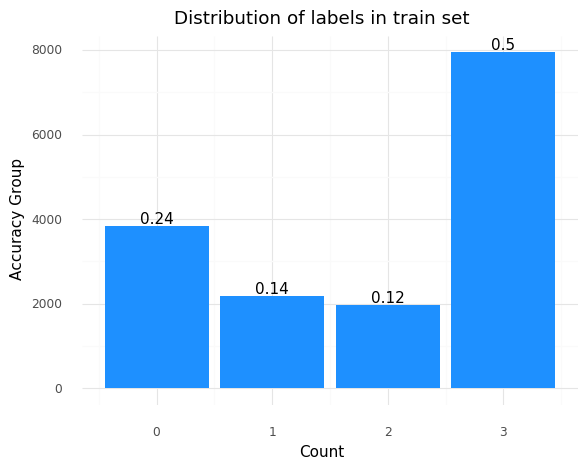

In [103]:
plot = ggplot(data=pd.DataFrame(train_y))\
        + geom_bar(aes(x='accuracy_group'),fill='dodgerblue')\
        + ggtitle('Distribution of labels in train set')\
        + geom_text(aes(x='accuracy_group',label='round(..prop..,2)'), stat='count',vjust='bottom')\
        + xlab('Count')\
        + ylab('Accuracy Group')\
        + theme_minimal()
plot.draw();

About half of the observations fall into group 3.  To balance this we chose balance out the classes using SMOTENC.

In [104]:
smote = SMOTENC([7,8])
train_x_smote,train_y_smote = smote.fit_resample(train_x,train_y)
train_x_smote = pd.DataFrame(train_x_smote,columns=X_col_names)

train_x_smote['installation_id'] = 1
train_x['installation_id'] = 1 

/Users/loftis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/Users/loftis/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/loftis/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./before_after_smote.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


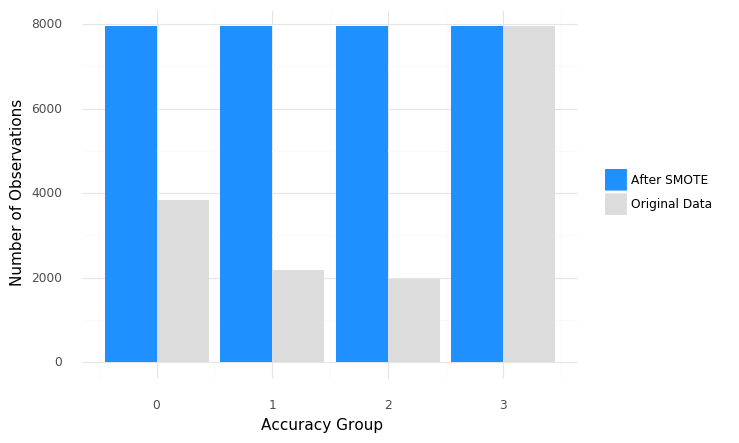

In [105]:
def plot_before_after_smote_y_dist():
    '''
    ggplot code to plot distribution of labels before and after SMOTENC resampling
    '''
    df1, df2 = (pd.DataFrame({'accuracy_group':train_y}),
                pd.DataFrame({'accuracy_group':train_y_smote}))
    df1['smote'] = 'Original Data'
    df2['smote'] = 'After SMOTE'
    df = pd.concat([df1,df2],axis=0)
    plot = (ggplot(data=df)+
            geom_bar(aes(x='accuracy_group',fill='smote'),position=position_dodge())+
            xlab('Accuracy Group')+
            ylab('Number of Observations')+
            theme_minimal()+
            theme(legend_title = element_blank())+
            scale_fill_manual(['dodgerblue','gainsboro']))
    return plot
plot = plot_before_after_smote_y_dist()
plot.save(filename='./before_after_smote.png',dpi=400)
plot.draw();

After SMOTENC resampling, the classes are balanced.  We will fit both the SMOTENC sampled data and on non-smote samples.

In [107]:
def evaluate_model(model,x,y,n_jobs=4):
    '''
    helper function to evaluate models.  Compute the 5 fold cross validation and prints 
    report of averge CV fold and training set scores for the following metrics:
        quadratic_cappa
        weighted_f1
        accuracy
    '''
    scorers = {'quadratic_cappa':make_scorer(cohen_kappa_score,weights='quadratic'),
               'weighted_f1':make_scorer(metrics.f1_score,average='weighted'),
               'accuracy':make_scorer(metrics.accuracy_score)}

    CV = cross_validate(model,x,y,cv=5,n_jobs=n_jobs,scoring=scorers,return_train_score=True)
    
    train_cv_quadrtic_cappa_mean = CV['train_quadratic_cappa'].mean()
    train_cv_quadrtic_cappa_std = CV['train_quadratic_cappa'].std()
    test_cv_quadrtic_cappa_mean = CV['test_quadratic_cappa'].mean()
    test_cv_quadrtic_cappa_std = CV['test_quadratic_cappa'].std()
    
    train_cv_weighted_f1_mean = CV['train_weighted_f1'].mean()
    train_cv_weighted_f1_std = CV['train_weighted_f1'].std()
    test_cv_weighted_f1_mean = CV['test_weighted_f1'].mean()
    test_cv_weighted_f1_std = CV['test_weighted_f1'].std()
    
    train_cv_accuracy_mean = CV['train_accuracy'].mean()
    train_cv_accuracy_std = CV['train_accuracy'].std()
    test_cv_accuracy_mean = CV['test_accuracy'].mean()
    test_cv_accuracy_std = CV['test_accuracy'].std()
    
    print(f'Quadratic Kappa mean Train: {train_cv_quadrtic_cappa_mean:.3f} std: {train_cv_quadrtic_cappa_std:.3f}')
    print(f'Quadratic Kappa mean CV: {test_cv_quadrtic_cappa_mean:.3f} std: {test_cv_quadrtic_cappa_std:.3f}')
    print()
    print(f'Weighted F1 mean Train: {train_cv_weighted_f1_mean:.3f} std: {train_cv_weighted_f1_std:.3f}')
    print(f'Weighted F1 mean CV: {test_cv_weighted_f1_mean:.3f} std: {test_cv_weighted_f1_std:.3f}')
    print()
    print(f'Accuracy mean Train: {train_cv_accuracy_mean:.3f} std: {train_cv_accuracy_std:.3f}')
    print(f'Accuracy mean CV: {test_cv_accuracy_mean:.3f} std: {test_cv_accuracy_std:.3f}')

In [108]:
preprocessor = ColumnTransformer([('onehot1',OneHotEncoder(),['assess_world']),
                                  ('onehot2',OneHotEncoder(),['assess_title']),
                                  ('drop', 'drop',['installation_id'])],
                                  remainder='passthrough')

In [109]:
dumb_pipe = Pipeline([('col_transform',preprocessor),
                      ('cls',DummyClassifier(strategy='uniform'))])

Start with a baseline model of random guesseing.

In [111]:
print(f'Random Model results')
print()
evaluate_model(dumb_pipe,train_x,train_y)

Random Model results

Quadratic Kappa mean Train: 0.000 std: 0.006
Quadratic Kappa mean CV: -0.001 std: 0.021

Weighted F1 mean Train: 0.268 std: 0.004
Weighted F1 mean CV: 0.270 std: 0.006

Accuracy mean Train: 0.250 std: 0.002
Accuracy mean CV: 0.250 std: 0.005


As expected does not perform well, but provides a base to compare more complex models to.

Try lasso logistic regression for both SMOTENC resampled data and non-resampled data

In [113]:
print(f'Lasso Logistic Regression results')
lasso_pipe = Pipeline([('col_transform',preprocessor),
                         ('cls',OneVsRestClassifier(lm.Lasso(normalize=True,max_iter=5000,alpha=2e-5)))])
evaluate_model(lasso_pipe,train_x,train_y.to_numpy())

Lasso Logistic Regression results
Quadratic Kappa mean Train: 0.495 std: 0.002
Quadratic Kappa mean CV: 0.488 std: 0.009

Weighted F1 mean Train: 0.526 std: 0.001
Weighted F1 mean CV: 0.521 std: 0.002

Accuracy mean Train: 0.610 std: 0.001
Accuracy mean CV: 0.606 std: 0.001


In [114]:
lasso_pipe.fit(train_x,train_y);

In [117]:
print(f'Lasso Smote Regression results')
lasso_smote_pipe = Pipeline([('col_transform',preprocessor),
                         ('cls',OneVsRestClassifier(lm.Lasso(normalize=True,max_iter=5000,alpha=2e-5)))])
evaluate_model(lasso_smote_pipe,train_x_smote,train_y_smote,n_jobs=1)

Lasso Smote Regression results
Quadratic Kappa mean Train: 0.484 std: 0.009
Quadratic Kappa mean CV: 0.478 std: 0.041

Weighted F1 mean Train: 0.445 std: 0.006
Weighted F1 mean CV: 0.439 std: 0.021

Accuracy mean Train: 0.471 std: 0.004
Accuracy mean CV: 0.465 std: 0.019


Note that the smote dataset actually performed worse for the lasso model.

In [118]:
lasso_smote_pipe.fit(train_x_smote,train_y_smote);

In [119]:
rf_pipe = Pipeline([('col_transform',preprocessor),
                 ('cls',RandomForestClassifier(n_estimators=250,
                                               max_features = int(np.sqrt(train_x.shape[1])),
                                               min_samples_leaf=10))])

In [120]:
print(f'Random Forest results')
evaluate_model(rf_pipe,train_x,train_y,n_jobs=1)

Random Forest results


/Users/loftis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/loftis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/loftis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/loftis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Quadratic Kappa mean Train: 0.617 std: 0.003
Quadratic Kappa mean CV: 0.480 std: 0.011

Weighted F1 mean Train: 0.617 std: 0.002
Weighted F1 mean CV: 0.526 std: 0.004

Accuracy mean Train: 0.686 std: 0.001
Accuracy mean CV: 0.614 std: 0.002


In [121]:
rf_pipe.fit(train_x,train_y);

In [124]:
print(f'Random Forest SMOTE results')
rf_smote_pipe = Pipeline([('col_transform',preprocessor),
                 ('cls',RandomForestClassifier(n_estimators=250,
                                               max_features = int(np.sqrt(train_x.shape[1])),
                                               min_samples_leaf=10))])
evaluate_model(rf_smote_pipe,train_x_smote,train_y_smote,n_jobs=1)

Random Forest SMOTE results
Quadratic Kappa mean Train: 0.766 std: 0.026
Quadratic Kappa mean CV: 0.608 std: 0.129

Weighted F1 mean Train: 0.845 std: 0.023
Weighted F1 mean CV: 0.663 std: 0.139

Accuracy mean Train: 0.844 std: 0.023
Accuracy mean CV: 0.673 std: 0.117


SMOTENC resampling help the Random Forest (RF) Model acheive a higher mean CV score, however the standard deviation of the scoring metrics are much higher than that of the RF model trained on the regular data.

In [125]:
rf_smote_pipe.fit(train_x_smote,train_y_smote);

In [126]:
gb_pipe = Pipeline([('col_transform',preprocessor),
                    ('cls',xgb.XGBClassifier(learning_rate=.01))])

In [ ]:
print('XGBoost Classifier Results')
evaluate_model(gb_pipe,train_x,train_y,n_jobs=1)

XGBoost Classifier Results


/Users/loftis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
gb_pipe.fit(train_x,train_y);

In [ ]:
gb_smote_pipe = Pipeline([('col_transform',preprocessor),
                    ('cls',xgb.XGBClassifier(learning_rate=.01))])
print('XGBoost Classifier SMOTE Results')
evaluate_model(gb_pipe,train_x_smote,train_y_smote)

In [ ]:
gb_smote_pipe.fit(train_x_smote,train_y_smote);

In [ ]:
models = {'Lasso':lasso_pipe,'Lasso w/ SMOTE':lasso_smote_pipe,
          'Random Forest':rf_pipe, 'Random Forest w/ SMOTE':rf_smote_pipe,
          'XGBoost':gb_pipe, 'XGBoost w/ SMOTE':gb_smote_pipe}

In [ ]:
def evaluate_models(models):
    for model_name,model in models.items():
        predictions = model.predict(test_x)
        kappa = cohen_kappa_score(predictions,test_y,weights='quadratic')
        f1 = metrics.f1_score(predictions,test_y,average='weighted')
        acc = metrics.accuracy_score(predictions,test_y)
        print(f'{model_name} Results')
        print(f'Quadratic Kappa: {kappa}')
        print(f'Weighted F1 score: {f1}')
        print(f'Accuracy F1 score: {acc}')
        print()
        

In [ ]:
evaluate_models(models)

In [ ]:
from rfpimp import *

In [ ]:
imp = importances(rf_smote_pipe,train_x,train_y)

In [ ]:
imp = imp.reset_index()

In [ ]:
top_imp = imp.head(10)

In [ ]:
top_imp

In [ ]:
top_imp

In [ ]:
top_imp['Feature'] = pd.Categorical(top_imp['Feature'],
                                     categories=list(top_imp['Features']),
                                   ordered=True)

In [ ]:
plot = ggplot(data = top_imp) +\
            geom_bar(aes(x='Feature',y='Importance'),
                     stat='identity',fill='dodgerblue')+\
            coord_flip()+\
            theme_minimal() +\
            labs(title='Feature Importance')

plot.save('importance.png',dpi=300)

In [ ]:
plot

In [ ]:
train_x.shape

In [ ]:
df = pd.DataFrame({'Assess Title':train_x.assess_title,'Accuracy Group':train_y})
df['key'] = 1
df = df.groupby(['Assess Title','Accuracy Group'],as_index=False).sum()
matrix = df.pivot(index='Assess Title',columns="Accuracy Group",values='key')

In [ ]:
plt.figure(dpi=200)
sns.heatmap(matrix,annot=True,fmt='d',cmap="Blues")
plt.title('Assessment and Count of Accuracy Group')

In [ ]:
specs.loc[specs.event_id=='b012cd7f','info'].to_list()

In [ ]:
specs.loc[specs.event_id=='c277e121','info'].to_list()

In [ ]:
test_preds = rf_smote_pipe.predict(test_x)

In [ ]:
plt.figure(dpi=300)
sns.heatmap(confusion_matrix(test_y.to_numpy(),test_preds),
            annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Accuracy Group')
plt.ylabel('True Accuracy Group')






In [ ]:
def prepare_submission(model,test_data):
    install_id = test_data.installation_id.to_numpy()
    test_data = test_data.drop('installation_id',axis=1)  # put installation_id at the end to be consistant with train_set
    test_data['installation_id'] = install_id             # otherwise the pipeline throws an error
    test_predictions = model.predict(test_data)
    submission_df = pd.DataFrame({'installation_id':test_data.installation_id.to_numpy(),
                                  'accuracy_group':test_predictions})
    return submission_df
test = prepare_submission(rf_smote_pipe,test_reduced)

In [ ]:
test.to_csv('submission.csv',index=False)